In [1]:
import datetime 
import pandas as pd 
import numpy as np
from pandas import DataFrame 

In [3]:
#数据导入
path = 'D://吴忱松//大三上//量化//Data//'
df_high = pd.read_csv(path + 'high_adj_fake.csv')
df_low = pd.read_csv(path + 'low_adj_fake.csv')
df_close = pd.read_csv(path+ 'ClosePrice_fake.csv')

In [8]:
df_high['hour_sta'] = df_high['hour'].apply(lambda x:datetime.datetime.strptime(x.split(' ')[0],'%Y/%m/%d'))
df_low['hour_sta'] = df_low['hour'].apply(lambda x:datetime.datetime.strptime(x.split(' ')[0],'%Y/%m/%d'))
df_close['hour_sta'] = df_close['hour'].apply(lambda x:datetime.datetime.strptime(x.split(' ')[0],'%Y/%m/%d'))

ValueError: time data '2013-01-04' does not match format '%Y/%m/%d'

In [27]:
#参数设置
k1 = 0.04
k2 = 0.02
n = 20
m=14
fee=0.0003  #万分之三的交易费用
sec="RB"  #期货合约代码

In [28]:
#计算日度行情
data_day = DataFrame()
data_day['high'] = df_high.groupby('hour_sta')[sec].max()
data_day['low'] = df_low.groupby('hour_sta')[sec].min()
data_day['close'] = df_close.groupby('hour_sta')[sec].last()
data_day['open'] = df_close.groupby('hour_sta')[sec].first()

In [29]:
#计算range,buy_line,sell_line
data_day[['high_max','close_max']] = data_day[['high','close']].rolling(n).max()
data_day[['low_min','close_min']] = data_day[['low','close']].rolling(n).min()
data_day['h-c'] = data_day['high_max'] - data_day['close_min']
data_day['c-l'] = data_day['close_max'] - data_day['low_min']
data_day['range'] = data_day[['h-c','c-l']].max(axis=1)
data_day['buy_line'] = data_day['open'] + k1 * data_day['range']
data_day['sell_line'] = data_day['open'] - k2*data_day['range']

In [30]:
df=df_close[sec]
df.index=df_close['hour_sta']
#将日度数据结果添加到分时数据中
df=pd.merge(df,data_day['buy_line'].shift(),left_index=True,right_index=True)
df=pd.merge(df,data_day['sell_line'].shift(),left_index=True,right_index=True)

In [31]:
# 生成信号
df.loc[df[sec]>df['buy_line'],'pos']=1
df.loc[df[sec]<df['sell_line'],'pos']=-1


<AxesSubplot:xlabel='hour_sta'>

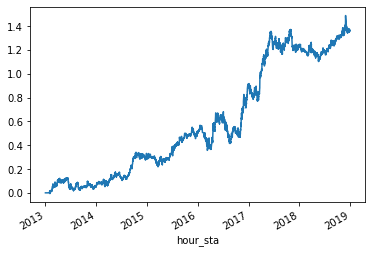

In [32]:
#计算回测结果，画累计收益率图像
df['pos']=df['pos'].fillna(method='ffill')
df['r']=df[sec].pct_change()
df['ret']=df['pos'].shift()*df['r']
df['fee']=fee*abs(df['pos'].diff())
df['Ret']=df['ret']-df['fee']
df['Ret']=df['Ret'].fillna(0)
df['Ret'].cumsum().plot()

In [33]:
df['Ret'].cumsum()[-1]

1.3653305932347268

In [5]:
df_result = pd.DataFrame(index=np.linspace(0,0.5,26), columns=np.linspace(0,0.5,26))

In [35]:
#参数优化，每次步长0.02
for k1 in np.linspace(0,0.5,26):
    for k2 in np.linspace(0,0.5,26):
        data_day['buy_line']=data_day['open']+k1*data_day['range']
        data_day['sell_line']=data_day['open']-k2*data_day['range']
        df=df_close[sec]
        df.index=df_close['hour_sta']
        #将日度数据结果添加到分时数据中
        df=pd.merge(df,data_day['buy_line'],left_index=True,right_index=True)
        df=pd.merge(df,data_day['sell_line'],left_index=True,right_index=True)
        #交易信号生成
        df.loc[df[sec]>df['buy_line'],'pos']=1
        df.loc[df[sec]<df['sell_line'],'pos']=-1
        #计算回测结果
        df['pos']=df['pos'].fillna(method='ffill')
        df['r']=df[sec].pct_change()
        df['ret']=df['pos'].shift()*df['r']
        df['fee']=fee*abs(df['pos'].diff())
        df['Ret']=df['ret']-df['fee']  
        ret_y = df['ret'].dropna().mean() * np.sqrt(4 * 252)
        ret_std = np.std(df['ret'].dropna()) * 4 * 252
        df_result.loc[k1,k2] = ret_y/ret_std
    

In [6]:
df_result

,0.00,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16,0.18,...,0.32,0.34,0.36,0.38,0.40,0.42,0.44,0.46,0.48,0.50
0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
df_result = df_result.stack()

In [37]:
df_result.loc[df_result == df_result.max()]

0.04  0.02    0.001024
dtype: object

In [52]:
#参数设置
k1 = 0.04
k2 = 0.02

In [53]:
#计算range,buy_line,sell_line
data_day[['high_max','close_max']] = data_day[['high','close']].rolling(n).max()
data_day[['low_min','close_min']] = data_day[['low','close']].rolling(n).min()
data_day['h-c'] = data_day['high_max'] - data_day['close_min']
data_day['c-l'] = data_day['close_max'] - data_day['low_min']
data_day['range'] = data_day[['h-c','c-l']].max(axis=1)
data_day['buy_line'] = data_day['open'] + k1 * data_day['range']
data_day['sell_line'] = data_day['open'] - k2*data_day['range']

In [54]:
#计算ATR
data_day['h-l']=data_day['high']-data_day['low']
data_day['c(-1)-h']=abs(data_day['close'].shift()-data_day['high'])
data_day['c(-1)-l']=abs(data_day['close'].shift()-data_day['low'])
data_day['TR']=data_day[['h-l','c(-1)-h','c(-1)-l']].max(axis=1)
data_day['ATR']=data_day['TR'].rolling(m).mean()


In [55]:
data_day['ATR_0.1'] = data_day['ATR'].rolling(240).quantile(0.1)

In [56]:
df=df_close[sec]
df.index=df_close['hour_sta']
#将日度数据结果添加到分时数据中
df=pd.merge(df,data_day['buy_line'].shift(),left_index=True,right_index=True)
df=pd.merge(df,data_day['sell_line'].shift(),left_index=True,right_index=True)
df=pd.merge(df,data_day['ATR'],left_index=True,right_index=True)
df = pd.merge(df,data_day['ATR_0.1'],left_index=True,right_index=True)

In [57]:
# 生成信号
df.loc[df[sec]>df['buy_line'],'pos']=1
df.loc[df[sec]<df['sell_line'],'pos']=-1
print('信号触发了%d次'%(df['pos'].count()))

信号触发了3836次


In [59]:
# ATR过滤
df.loc[df['ATR']<df['ATR_0.1'], 'pos']=0
num=np.sum(np.abs(df['pos'].dropna()))
print('信号触发了%d次'%(num))

信号触发了2932次


<AxesSubplot:xlabel='hour_sta'>

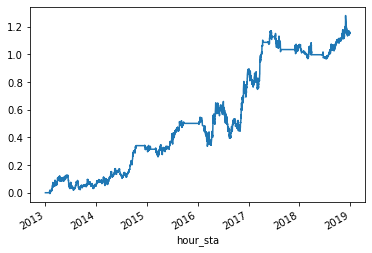

In [60]:
#计算回测结果，画累计收益率图像
df['pos']=df['pos'].fillna(method='ffill')
df['r']=df[sec].pct_change()
df['ret']=df['pos'].shift()*df['r']
df['fee']=fee*abs(df['pos'].diff())
df['Ret']=df['ret']-df['fee']
df['Ret']=df['Ret'].fillna(0)
df['Ret'].cumsum().plot()

In [61]:
df.Ret.cumsum()[-1]

1.158449692774579